# Description

This Notebook was motivated by this paper (https://arxiv.org/abs/2111.06377). After reading it, I was interested in the SIFT algorithm which could be used for my thesis work. Then after the discussion in class, I was interested in what other simpler methods of comparing images there are that could possibly be used for my situation. At the moment, I am comparing images that are not any different in scale and not very different in lighting (given the inherent cloudless nature of the Sentinel 2 Clousless Data). Upon some quick research into what simpler methods existed given these constraints, I came across normalized cross-correlation. I decided to try to program this in Numpy and see how it would work comparing the hexagon regions of images as I am doing in my thesis. The results are very interesting/promising. 

In [1]:
import sys
sys.path.insert(0, './../src')
from  feature_extraction  import FIASS_Embedding, Query_Image, Refrence_Image

FIASS = FIASS_Embedding()

refrence_image = Refrence_Image('./../images/2016.png', FIASS, 50, True)
query_image = Query_Image('./../images/2018.png', FIASS, 50, True)

/opt/anaconda3/envs/research/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


Done with GETTING HEXAGONS
Done with SAVING HEXAGONS
Done with SUPER
Index loaded from ./../images/2016/hexagon_images/indexes/index
Done with GETTING HEXAGONS
Done with SAVING HEXAGONS


In [29]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
"""
Function: Getting a matrix of probabilites the normalized cross-correlation between the query_image and each hex in the refrence image
Inputs:
      query_image 
      refrence_image
      position: grid position of query image hex to compare to refrence image 
      color_scheme: whether to compare in grayscale or RGB
Outputs:
      result: matrix with values representing the cross-correlation between the query_image and each hex in the refrence image
"""
def get_result_matrix(query_image, refrence_image, positon, color_scheme= 'L'):

      img = query_image.hexagon_images[positon[0]][positon[1]]
      img_gray = img.cropped_image
      si = img_gray.size
      img_gray = np.array(img_gray.convert(color_scheme))
      
      result = np.zeros((len(refrence_image.hexagon_images), len(refrence_image.hexagon_images[0])))
      for i in range(1, result.shape[0]-1):
            for j in range(1, result.shape[1]-1):
                  img_2 =refrence_image.hexagon_images[i][j].cropped_image.convert(color_scheme)
                  if(img_2.size !=si):
                        img_2 = img_2.resize(si)
                  img_2 =  np.array(img_2)
                  if(img_2.shape != img_gray.shape):
                        result[i, j] = 0
                  else:
                        if(len(img_gray.shape) > 2):
                              channels = img_gray.shape[2]
                              for channel in range(channels):
                                    result[i, j] += np.sum(img_gray[:,:,channel] * img_2[:,:,channel]) / np.sqrt(np.sum(img_gray[:,:,channel]**2) * np.sum(img_2[:,:,channel]**2))
                                    # err = np.sum((img_gray[:,:,channel] - img_2[:,:,channel]) ** 2)
                                    # err /= float(img_gray.shape[0] * img_gray.shape[1])
                                    # result[i, j] += err
                        else:
                              
                              result[i, j] += np.sum(img_gray * img_2) / np.sqrt(np.sum(img_gray**2) * np.sum(img_2**2))
                              # err = np.sum((img_gray.astype("float") - img_2.astype("float")) ** 2)
                              # err /= float(img_gray.shape[0] * img_gray.shape[1])
                              # result[i, j] += err
                  # print((j,i), si, result[i, j])
                              
      result = np.nan_to_num(result)
      # best_match = np.unravel_index(np.argmax(result), result.shape)
      return result / result.max()

"""
Function: Plot the Refrence Image with hexes being more white the lower their cross-correlation score and a red box for the highest scored hex and green for the correct hex
Inputs:
      refrence_image 
      prob_matrix: matrix of scores 
      best_position: highest scored position
Outputs:
      None
"""

def plot_uncertinity(refrence_image, prob_matrix, position, best_position):
      
      fig, ax = plt.subplots()
      ax.set_aspect('equal')
      for i, row in enumerate(refrence_image.hexagon_images[1:-1], 1):
            for y, hex_img in enumerate(row[1:-1], 1):
                  
                        
                  hex_img_image = hex_img.image
                  
                  prob = prob_matrix[i][y]
                  tint_color = (255, 255, 255)  # Red tint

                  # Create a solid color image with the same size as the original image
                  solid_color_image = Image.new("RGB", hex_img_image.size, tint_color)
                  
                  # Extract the alpha channel from the first image
                  alpha_channel = hex_img_image.getchannel('A')

                  # Merge the second image with the alpha channel from the first image
                  img_with_new_alpha = Image.merge("RGBA", (*solid_color_image.split()[:3], alpha_channel))
                  
                  
                  # Blend the original image with the tint color
                  tinted_image = Image.blend(hex_img_image, img_with_new_alpha, alpha=0.5*(1-prob))  # alpha controls the tint intensity
                  if((i,y) == best_position):
                        imageBox = hex_img.bbox
                        draw = ImageDraw.Draw(tinted_image)
                        draw.rectangle(imageBox, outline="red", width=10)
                  
                  if((i,y) == position):
                        imageBox = hex_img.bbox
                        draw = ImageDraw.Draw(tinted_image)
                        draw.rectangle(imageBox, outline="green", width=10)
                  ax.imshow(tinted_image)

      ax.set_xlim(0, hex_img_image.size[0])
      ax.set_ylim(hex_img_image.size[1], 0)
      ax.axis('off')

      plt.show()

"""
Function: Compute Score Matrix, Visualise Image, and print out metrics 
Inputs:
      position: position of hex in query image  
      query_image
      refrence_image
      color_scheme
Outputs:
      None
Prints: 
      Position compared 
      Predicted Position: the position with the highest cross-correlation score 
      Value of Real Position in Score Matrix
      Upper Quartile of Score Matrix
      Query Image Hex at given position
      Refrence Image Hex at given position
      Query Image Hex at position with highest score
      Refrence Image Hex at position with highest score

"""
def get_results(position, query_image, refrence_image, color_scheme = "L"):
      
      prob_matrix = get_result_matrix(query_image, refrence_image, position, color_scheme)
      max_index = np.unravel_index(np.argmax(prob_matrix), prob_matrix.shape)
      plot_uncertinity(refrence_image, prob_matrix, position, max_index)
      
      
      q_img = query_image.hexagon_images[position[0]][position[1]].cropped_image
      r_img = refrence_image.hexagon_images[position[0]][position[1]].cropped_image

      
      
      best_img = query_image.hexagon_images[max_index[0]][max_index[1]].cropped_image
      best_img_r = refrence_image.hexagon_images[max_index[0]][max_index[1]].cropped_image

      
      print("Position",position)
      print("Predicted Position",max_index)
      print("Value of Real Position in Score Matrix",prob_matrix[position])
      print("Percentile of Score Matrix", (prob_matrix < prob_matrix[position]).mean())
      print("Query Image")
      display(q_img.convert(color_scheme))
      print("Refrence Image")
      display(r_img.convert(color_scheme))
      print("Best Match")
      display(best_img.convert(color_scheme))
      print("Best Match Refrence")
      display(best_img_r.convert(color_scheme))

### Comparisons with a larger hex size 

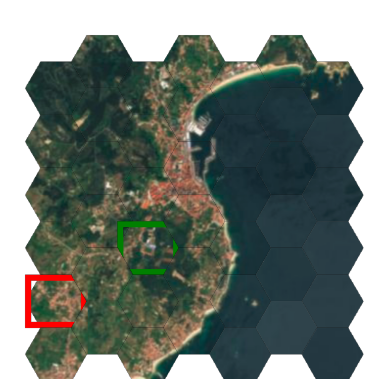

Position (4, 3)
Predicted Position (5, 1)
Value of Real Position in Score Matrix 0.9796466595415391
Percentile of Score Matrix 0.7916666666666666
Query Image


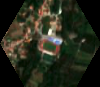

Refrence Image


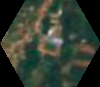

Best Match


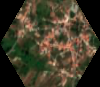

Best Match Refrence


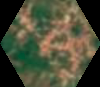

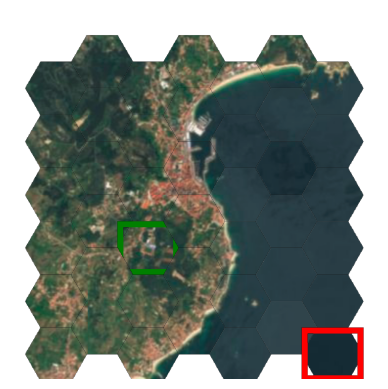

Position (4, 3)
Predicted Position (6, 7)
Value of Real Position in Score Matrix 0.9220093892471294
Percentile of Score Matrix 0.8472222222222222
Query Image


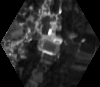

Refrence Image


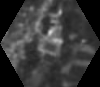

Best Match


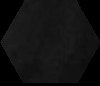

Best Match Refrence


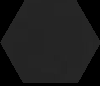

In [30]:
position = (4,3)
get_results(position, query_image, refrence_image, 'RGB')
get_results(position, query_image, refrence_image, 'L')

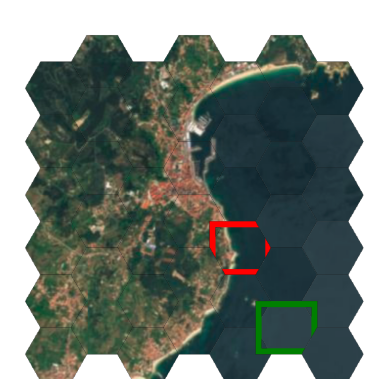

Position (6, 6)
Predicted Position (4, 5)
Value of Real Position in Score Matrix 0.7857124587693619
Percentile of Score Matrix 0.4166666666666667
Query Image


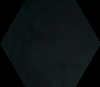

Refrence Image


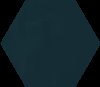

Best Match


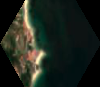

Best Match Refrence


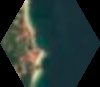

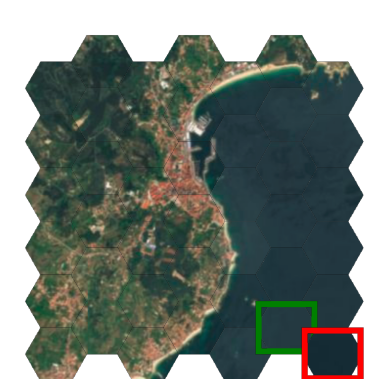

Position (6, 6)
Predicted Position (6, 7)
Value of Real Position in Score Matrix 0.8721524373357713
Percentile of Score Matrix 0.5416666666666666
Query Image


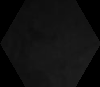

Refrence Image


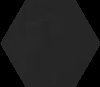

Best Match


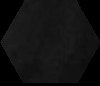

Best Match Refrence


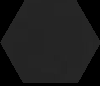

In [31]:
position = (6,6)
get_results(position, query_image, refrence_image, 'RGB')
get_results(position, query_image, refrence_image,'L')

### Comparisons with a smaller hex size 

In [5]:
import sys
sys.path.insert(0, './../src')
from  feature_extraction  import FIASS_Embedding, Query_Image, Refrence_Image

FIASS = FIASS_Embedding()

refrence_image_smaller = Refrence_Image('./../images/2016.png', FIASS, 10, True)
query_image_smaller = Query_Image('./../images/2018.png', FIASS, 10, True)

Done with GETTING HEXAGONS
Done with SAVING HEXAGONS
Done with SUPER
Index loaded from ./../images/2016/hexagon_images/indexes/index
Done with GETTING HEXAGONS
Done with SAVING HEXAGONS


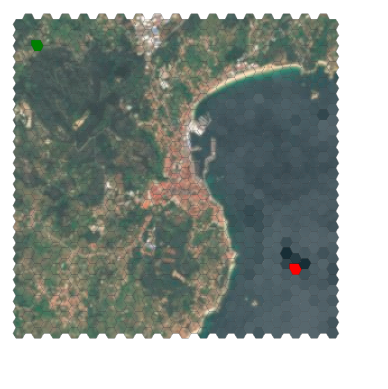

Position (3, 3)
Predicted Position (24, 31)
Value of Real Position in Score Matrix 0.6470402925164506
Percentile of Score Matrix 0.9594594594594594
Query Image


Refrence Image


Best Match


Best Match Refrence


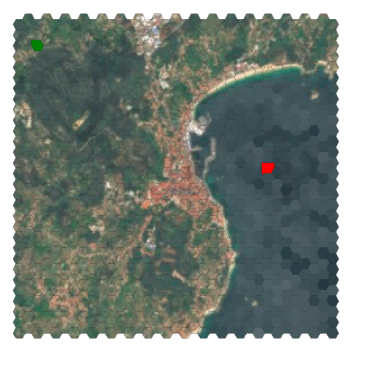

Position (3, 3)
Predicted Position (15, 28)
Value of Real Position in Score Matrix 0.6341370450233706
Percentile of Score Matrix 0.4206081081081081
Query Image


Refrence Image


Best Match


Best Match Refrence


In [32]:
position = (3,3)
get_results(position, query_image_smaller, refrence_image_smaller, 'RGB')
get_results(position, query_image_smaller, refrence_image_smaller, 'L')

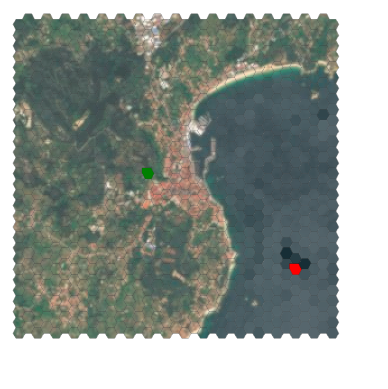

Position (15, 15)
Predicted Position (24, 31)
Value of Real Position in Score Matrix 0.5666388253585892
Percentile of Score Matrix 0.42989864864864863
Query Image


Refrence Image


Best Match


Best Match Refrence


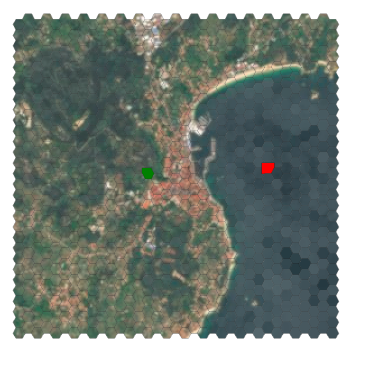

Position (15, 15)
Predicted Position (15, 28)
Value of Real Position in Score Matrix 0.6655945705710816
Percentile of Score Matrix 0.6655405405405406
Query Image


Refrence Image


Best Match


Best Match Refrence


In [33]:
position = (15,15)
get_results(position, query_image_smaller, refrence_image_smaller, 'RGB')
get_results(position, query_image_smaller, refrence_image_smaller, 'L')

## Results

The results of this work are very interesting. The cross-correlation is unable to perfectly match up the query and refrence image for either hex size, position, or color-scheme. However, in inputs that are expected to yeild a good matching (distinctive buildings and large hex sizes) the value of the cross correlation for the correct hex is in above 75th percentile for the score matrix. This means that while it is unable to locatate exactly which hex in the refrence image corresponds to the query image, it can do a good job rulling out at least 75% of the hexes. 

The larger hex size compared to the smaller hex sizes have much higher scores in the true positon which is expected, given they have more pixels they can compare and more distinguishable features. Additionally, as expected, when the query image is more distinguishable (buildings instead of land or water), it is able to be much more accurately scored. 

As for the color scheme, it seems that the grayscale color scheme works better to line up the images than the RGB, with a higher score in most examples. This makes sense as the colors are slightly different in the query and refrence images as a result of changes in lighting and clarity of photo from the refrence to the query image. This is also convient as computing the cross-correlation values for the grayscale images takes one-third the amount of cacualtions compared to the RGB values. 

Overall, the cross correlation may be too basic to exactly match up the query image to the correspond hex on the refrence image. (I also tested MSE but that did worse) However, it does a nice job rulling out a descent amount of hexes and non-matches. For the purposes of a system that has some knowledge about its position, it can then narrow down further the canidates and hopefully get a more accurate perdiction of where it is. 